In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###  Cut the required image size

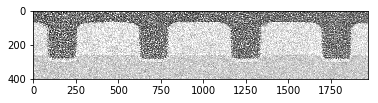

In [2]:
%matplotlib inline
image = cv2.imread('./AEI_G10_60K.tif')
image = image[260:660, :, :]
img = image[:, :, 0]
plt.imshow(img, cmap='gray')
plt.show()

### Define the blue and sobel functions

In [3]:
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # img = np.copy(image)
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #because this uses mpimg to read image
    gray = np.copy(image)
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'*1) + int(orient=='y'*0),int(orient=='x'*0) + int(orient=='y'*1))
    sobel = np.absolute(sobel)
    sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel >= thresh[0])&(sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # image = np.copy(img)
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.copy(img)
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = np.uint8(255*sobel/np.max(sobel))
    mag_binary = np.zeros_like(sobel_x)
    mag_binary[(sobel>=mag_thresh[0])&(sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # image = np.copy(img)
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.copy(img)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def sobel_filter(img, para):
    ksize = 5
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=para['grad_thresh'])
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=para['grad_thresh'])
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=para['mag_min'])
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=para['dir_thresh'])

    sobel_binary = np.zeros_like(gradx)
    sobel_binary[(gradx == 1) & (mag_binary == 1) & (mag_binary == 1)] = 1
    return sobel_binary

### Blur the image to reduce noise

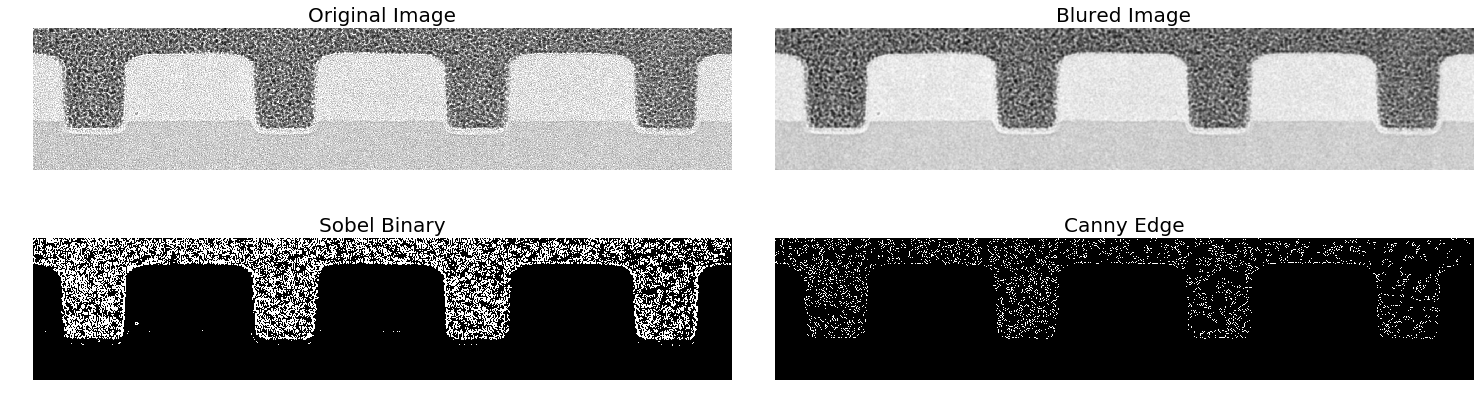

In [4]:
img_blur = gaussian_blur(img, 11)

para ={'grad_thresh': (20, 225),
       'mag_min': (60, 205),
       'dir_thresh':(0., np.pi/2)}
img_sobel = sobel_filter(img_blur, para)
img_canny = cv2.Canny(img_blur,80,200)

f, ax = plt.subplots(2, 2, figsize=(20, 6))
f.tight_layout()
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[0, 1].imshow(img_blur, cmap='gray')
ax[0, 1].set_title('Blured Image', fontsize=20)
ax[0, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 0].imshow(img_sobel, cmap='gray')
ax[1, 0].set_title('Sobel Binary', fontsize=20)
ax[1, 0].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 1].imshow(img_canny, cmap='gray')
ax[1, 1].set_title('Canny Edge', fontsize=20)
ax[1, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply sobel filter to extract the edges

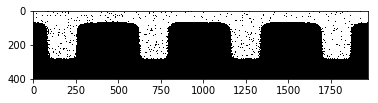

In [5]:
# epsilon = 0.1 # 0.1*cv2.arcLength(img_sobel,True)
# approx = cv2.approxPolyDP(img_sobel,epsilon,True)

ret, thresh = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# plt.plot(approx)
plt.imshow(thresh, cmap='gray')
plt.show()

In [26]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=2)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

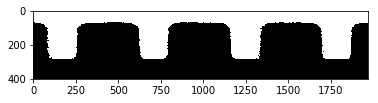

In [27]:
%matplotlib inline
plt.imshow(sure_bg, cmap = 'gray')
plt.show()

In [7]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [20]:
sure_fg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

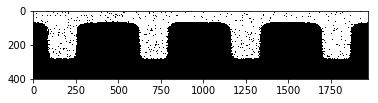

In [17]:
%matplotlib inline
plt.imshow(opening, cmap = 'gray')
plt.show()
markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]

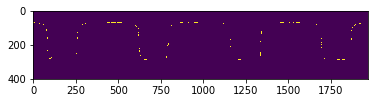

In [15]:
img_canny2 = cv2.Canny(sure_bg,100,200)
plt.imshow(opening)
plt.show()